Hello Flatlanders!
===
Or soon to be flatlanders at least!

In this set of notebooks I'm going to play around with uses for dimensionality reduction 
I like dimesnionality recution for many reasons, and it's rather useful in program and data analysis. As with all the notebooks here this is just for hobby and toy examples to help me learn the concepts and to offer me a set of examples to go back to when I actually need these techniques.

There are many good reasons to like dimensioality reduction, however, if I'm being honest, I like DR because it's pretty. DR is often used to help classify and organize sets of data. You can take data will million or more features and reduce it down to around 100 key components and then in that ~100D space you can craft classifiers and clusters to organize your data. And if you desire, you can go straight to 2 or 3 dimensions from you high dimensional space, or your lower (but still larger than we're visually use to) dimensional space 

And I'm tired of writing this bit, 
DR is cool. There's lots of ways to do it,
where your smaller dims, x, y, z, are some linear combination of your previous $N$ dims (which is used in many modern classifiers due to speed and memory) or where x, y, z, are some non linear combination ($x=N_{i}^{2}-3N_{j}^{\frac{1}{2}}$, $y=...$, $z=...$)

These different ways to combine your data have large impacts on how your final output is distributed, and depending on how your features are related, some methods will offer more insightful visualizations than others.

We'll get to it, I'm tired of this, Hurray I'm going to see if that latex bit worked out..
(It did but I forgot the closing ')')

Ok, Because I haven't yet gotten to play with this, I'm going to bring in my Free Book dataset. One night I drank a half pint of whiskey and (by hand so as not to violate the website rules) downloaded most of the top 1oo free ebooks from Project Gutenberg. 

I'm going to do a really cheap parsing where it's all lowercase, and only split on ' ', '\n', '\t', '\r' (Why does '\r' exist?) We're also going to implement a lantent semantic library based on my lsalib, but all the code will be hosted here because I need to review and update that library anyway, so why not! :D

In [60]:
# All imports will be done here
# Not my libraries
import os
import sys
import numpy
import math 
from sklearn.decomposition import ProjectedGradientNMF
import re

# My personal Libraries 
import kmlistfi

In [61]:
fls = kmlistfi.les('/home/keith/Documents/Databases/Datasets/GutTop100Books/')

In [62]:
len(fls)

99

In [63]:
# Ok for now this is a block copy and paste
#    but I'm tired, such is as it is
class termDocMatrix(object):
    def __init__(self, saveVerbose=True, wcThreshold=2, parseOn=" "):
        # Get term-document matrix
        # transormation/modified weighting of term-doc matrix 
        # dimensionality reduction
        # clustering of documents in reduced space
        self.wcThreshold = wcThreshold
        self.saveVerbose = saveVerbose
        self.parseOn = parseOn
        self.mD = {}
        self.tdm = []
        self.tdmraw = []
        self.termraw = []
        self.docs = []
        self.docsSize = []
        self.terms = []
        self.docCount = 0
        self.idfweight = False
        self.P = []
        self.Q = []
        self.er = []
        self.idfs = []
        return
    def add(self, newThing, docs=""):
        def _mergeDict(self, newD, docs=""):
            # Grab doc count so far
            docIndex = self.docCount
            # Get the correct title
            if docs == "":
                docs = docIndex
            self.docs.append(docs)
            # Add doc size (useful with tdmraw)
            tdWeight = float(sum(newD.values()))
            if tdWeight == 0:
                tdWeight = 1.
            self.docsSize.append(tdWeight)
            # Add newD to mD
            for key in newD:
                if key in self.mD:
                    if len(self.mD[key]) < self.docCount:
                        for i in range(len(self.mD[key]), self.docCount):
                            self.mD[key].append(0.)
                    self.mD[key].append(newD[key]/float(tdWeight))
                else:
                    if self.docCount > 0:
                        self.mD[key] = [0.]
                        for i in range(1, self.docCount):
                            self.mD[key].append(0.)
                        self.mD[key].append(newD[key]/float(tdWeight))
                    else:
                        self.mD[key] =  [newD[key]/float(tdWeight)]
            self.docCount += 1
            return 
            
        
        # Ok what was I just given?
        if type(newThing) == list:
            # Shit.. Ok we can handle this, a list of what?
            if len(newThing) > 0:
                if type(newThing[0]) == dict:
                    # Sweet, it's some dicts, merge them!
                    # Wait, what about the title var?
                    if (docs != "") and (type(docs) == list) and (len(docs) == len(newThing)):
                        for i in range(len(newThing)):
                            _mergeDict(self, newThing[i], docs[i])
                    else:
                        for i in range(len(newThing)):
                            _mergeDict(self, newThing[i])

                elif type(newThing[0]) in [float, long, int, str, unicode]:
                    # Well, I mean I don't see why numbers can't be LSA'ized
                    # Convert list to dict, then merge
                    newD = {}
                    for i in range(len(newThing)):
                        if newThing[i] in newD:
                            newD[newThing[i]] += 1
                        else:
                            newD[newThing[i]] = 1
                    _mergeDict(self, newD, docs)
                else:
                    raise(TypeError, "Elements of list are not valid inputs")

                

        elif type(newThing) == dict:
            # Woo this is simple!
            _mergeDict(self, newThing, docs)

        elif type(newThing) == str:
            # I'm assuming I'm to add this string to the term doc Matrix
            strList = newThing.split(self.parseOn)
            newD = {}
            for i in range(len(strList)):
                if strList[i].strip() in newD:
                    newD[strList[i].strip()] += 1
                else:
                    newD[strList[i].strip()] = 1
            _mergeDict(self, newD, docs)
        return

    def weight_idf(self):
        # Now we're weighting it, booyea
        # The weighting applied here is idf, and assumes td weighting was applied earlier
        #   idf: inverse document frequency: log(N/ni)
        #     if every doc has word ni, the it zeros out the row
        #     Rather than math it, check for it first
        self.idfweight = True
        for key in self.mD:
            # Saving raw state allows matrix to grow w/o redoing everything
            # only done if 
            if self.saveVerbose == True:
                self.termraw.append(key)
            # This chunk is to check for the idf weight condition:
            #   if every doc has the term, then it's not worth 'mathing'
            #   and instead can be eliminated
            idf = False
            if len(self.mD[key]) < self.docCount:
                idf = True
                for i in range(len(self.mD[key]), self.docCount):
                    self.mD[key].append(0.)
            # Saving raw matrix
            if self.saveVerbose == True:
                self.tdmraw.append(self.mD[key])
            # Scan row for a zero
            if idf == False:
                for i in range(len(self.mD[key])):
                    if self.mD[key][i] == 0:
                        idf = True
                        break
            # CURRENTLY AN ERROR DUE TO TD WEIGHTING EARLIER: FIXED
            if (len(filter(None, self.mD[key])) >= self.wcThreshold) and idf == True:
                self.terms.append(key)
                self.tdm.append(self.mD[key])
        
        # Ok now it's actually time to start weighting
        self.tdm = numpy.array(self.tdm)
        #print len(self.tdm)
        for i in range(len(self.tdm)):
            #print self.terms[i]
            ni = float(numpy.count_nonzero(self.tdm[i]))
            if ni == 0:
                raise ValueError("ARG HOW ARE THERE NO NON ZERO ELIMENTS")
            #print ni, self.docCount
            idfValue = math.log(self.docCount/ni)
            self.tdm[i] = self.tdm[i] * idfValue
            self.idfs.append(idfValue)
            
        return

    def svd(self):
        return

    def spectralEmbed(self, k, n_neighbors=10):
        from sklearn import manifold
        se = manifold.SpectralEmbedding(n_components=k, n_neighbors=n_neighbors)
        Yse = se.fit_transform(self.tdm)
        print len(Yse)
        return Yse

    def nmf(self, k):
        
        nmf = ProjectedGradientNMF(n_components=k, max_iter=200)
        P = nmf.fit_transform(self.tdm)
        Q = nmf.components_.T
        self.P = P
        self.Q = Q
        self.er = nmf.reconstruction_err_
        print "\tNMF Error: ", self.er
        return P, Q

In [70]:
tdm = termDocMatrix()
for i in range(25):#len(fls)):
    flname = fls[i]
    fl = open(flname, 'r')
    lines = fl.read()
    fl.close()
    flname = flname.split('/')[-1][:-4]
    print '\t', i, '\t', flname
    line = re.sub('[\t\n\r]', ' ', lines)
    line = line.lower()
    line = line.split(' ')
    tdm.add(line, flname)

	0 	TheCompleteWorksofWilliamShakespeare
	1 	AStudyInScarlet
	2 	EthanFrome
	3 	DemocracyandEducation
	4 	BeyondGoodAndEvil
	5 	Siddhartha
	6 	OliverTwist
	7 	DonQuixote
	8 	DrJekyllandMrHyde
	9 	Metamorphosis
	10 	WarAndPeace
	11 	ThroughTheLookingGlass
	12 	JosefineMutzenbacher
	13 	TheHoundoftheBaskervilles
	14 	TragicalHistoryofDrFaustus
	15 	CrimeandPunishment
	16 	theJunbleBook
	17 	AChristmasCarol
	18 	OnLiberty
	19 	AModestPurposal
	20 	HeartofDarkness
	21 	DonJuan
	22 	PeterPan
	23 	HowtoAnalyzePeopleonSight
	24 	Persuasion


In [71]:
# Worth a shot
tdm.weight_idf()


In [73]:
tdm.nmf(2)

/home/keith/anaconda2/lib/python2.7/site-packages/sklearn/utils/__init__.py:75: DeprecationWarning: Class ProjectedGradientNMF is deprecated; It will be removed in release 0.19. Use NMF instead.'pg' solver is still available until release 0.19.
  warnings.warn(msg, category=DeprecationWarning)
/home/keith/anaconda2/lib/python2.7/site-packages/sklearn/decomposition/nmf.py:775: DeprecationWarning: 'pg' solver will be removed in release 0.19. Use 'cd' solver instead.
  " Use 'cd' solver instead.", DeprecationWarning)


	NMF Error:  0.0360107696639


(array([[  3.71110784e-10,   1.40526282e-03],
        [  2.17111518e-08,   3.11331559e-04],
        [  3.67214579e-08,   1.68409481e-05],
        ..., 
        [  2.65324757e-09,   1.19103710e-06],
        [  1.34616985e-08,   1.95471180e-06],
        [  3.61446974e-09,   1.90795851e-06]]),
 array([[  2.58290371e-05,   2.43759894e-03],
        [  1.13121946e-05,   2.15447858e-03],
        [  1.96581378e-06,   1.76409662e-03],
        [  3.42357578e-06,   6.22761617e-04],
        [  4.19220374e-05,   6.57531294e-04],
        [  2.86548301e-06,   1.34219600e-03],
        [  1.14586282e-05,   8.47657940e-03],
        [  1.29015025e-05,   3.99679618e-03],
        [  1.27758914e-05,   1.36318154e-03],
        [  1.55727801e-05,   1.45678936e-03],
        [  8.48072784e-05,   2.72890298e-03],
        [  0.00000000e+00,   1.28769065e-01],
        [  3.32202001e-01,   0.00000000e+00],
        [  5.07270544e-06,   1.61167678e-03],
        [  2.37704165e-05,   2.76384061e-03],
        [  3.96864

In [67]:
print len(tdm.Q), len(tdm.P), len(tdm.docs)

25 55824 25


25 2


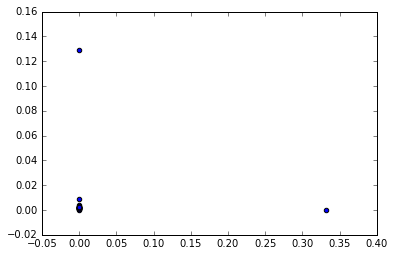

In [74]:


from matplotlib.pyplot import figure, show
import numpy as npy
from numpy.random import rand

temp = zip(*tdm.Q)
x = temp[0]
y = temp[1]
print len(x), len(temp)

if 1: # picking on a scatter plot (matplotlib.collections.RegularPolyCollection)

    
    def onpick3(event):
        ind = event.ind
        print ind, type(ind)
        if type(ind) == numpy.ndarray:
            print "YOU"
            ind = ind[0]
        print 'onpick3 scatter:', tdm.docs[ind]#, npy.take(x, ind), npy.take(y, ind)

    fig = figure()
    ax1 = fig.add_subplot(111)
    col = ax1.scatter(x, y, picker=True)
    #fig.savefig('pscoll.eps')
    fig.canvas.mpl_connect('pick_event', onpick3)



In [76]:
# Aaaand now I can't undo inline plotting
# I stand by matplotlib is a pain
# In other news I'm waiting on spectral embedding to finish 
# in the command line because I guess sleep isn't needed

#soo.. I'll do it hsere too

Yse = tdm.spectralEmbed(2)

KeyboardInterrupt: 

In [ ]:

temp = zip(*Yse)
x = temp[0]
y = temp[1]
print len(x), len(temp)

if 1: # picking on a scatter plot (matplotlib.collections.RegularPolyCollection)

    
    def onpick3(event):
        ind = event.ind
        print ind, type(ind)
        if type(ind) == numpy.ndarray:
            print "YOU"
            ind = ind[0]
        print 'onpick3 scatter:', tdm.docs[ind]#, npy.take(x, ind), npy.take(y, ind)

    fig = figure()
    ax1 = fig.add_subplot(111)
    col = ax1.scatter(x, y, picker=True)
    #fig.savefig('pscoll.eps')
    fig.canvas.mpl_connect('pick_event', onpick3)


Dear lord this is why people like linear
Get your act together SE, you're pretty much my 
favorite NLDR method and you're being a total pain